<a href="https://colab.research.google.com/github/stvngo/Algoverse-AI-Model-Probing/blob/main/Linear_Probing_Classifier_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Probing Classifiers

Probing classifer notes:

- probing classifiers can be used to identify if the model actually contains the relevant information or knowledge required to make a correct prediction on a task, or if it was just lucky
- they identify specific components in the model that contain this relevant information
- a probe is a simple model that uses the representations of the model as input, and tries to learn the downstream task from them. they are designed to be too easy to learn the task on its own. they easily separate the representations from the model as a classifier
- the probe will perform well on this task only if the representations it is given are already good enough to make the prediction
- generally, using the representations from the last layers help identify if the model even contains the info to make predictions for the task
- extended further to different layers to identify where info is stored and transformed
- used in NLP to check if LMs contain certain kinds of linguistic info
- can be simple or complex

Limitations:

- what is the correct architectural design of the probe (cannot be too simple or too complex)
- a probe can only tell us if a part of the model *can* make the prediction, not if it *does* (model may use use different representations other than the probe's trained representations)
- causal tracing addresses this by finding which part of the model contains the relevant info for the task. iterates through all parts of the model (all layers), disrcupting the info flow through that part of the model, if model performance on task suddenly drops on discrupting a specific component, that component contains the info to make the prediction and the model is actually using that info to make the prediction.

**Taken from https://carpentries-incubator.github.io/fair-explainable-ml/5c-probes.html**

In [5]:
!pip install datasets --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [1]:
import os
import torch
import logging
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from datasets import load_dataset, Dataset
from transformers import AutoModel, AutoTokenizer, AutoConfig

logging.basicConfig(level=logging.INFO)
os.environ['TOKENIZERS_PARALLELISM'] = 'false'  # This is needed to avoid a warning from huggingface

In [2]:
# Set random seeds for reproducibility - pick any number of your choice to set the seed. We use 42, since that is the answer to everything, after all.
torch.manual_seed(42)

torch.set_default_device('cuda') if torch.cuda.is_available() else torch.set_default_device('cpu')

Load dataset

In [3]:
def load_imdb_dataset(keep_samples: int = 100) -> Tuple[Dataset, Dataset, Dataset]:
    '''
    Load the IMDB dataset from huggingface.
    The dataset contains text reviews and their corresponding sentiment labels (positive or negative).
    The label 1 corresponds to a positive review, and 0 corresponds to a negative review.
    :param keep_samples: Number of samples to keep, for faster training.
    :return: train, dev, test datasets. Each can be treated as a dictionary with keys 'text' and 'label'.
    '''
    dataset = load_dataset('stanfordnlp/imdb')

    # Keep only a subset of the data for faster training
    train_dataset = Dataset.from_dict(dataset['train'].shuffle(seed=42)[:keep_samples])
    dev_dataset = Dataset.from_dict(dataset['test'].shuffle(seed=42)[:keep_samples])
    test_dataset = Dataset.from_dict(dataset['test'].shuffle(seed=42)[keep_samples:2*keep_samples])

    # train_dataset[0] will return {'text': ...., 'label': 0}
    logging.info(f'Loaded IMDB dataset: {len(train_dataset)} training samples, {len(dev_dataset)} dev samples, {len(test_dataset)} test samples.')
    return train_dataset, dev_dataset, test_dataset

In [4]:
train_dataset, dev_dataset, test_dataset = load_imdb_dataset(keep_samples=50)

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Load model and tokenizer

In [5]:
def load_model(model_name: str) -> Tuple[AutoModel, AutoTokenizer]:
    '''
    Load a model from huggingface.
    :param model_name: Check huggingface for acceptable model names.
    :return: Model and tokenizer.
    '''
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    config = AutoConfig.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name, config=config)
    model.config.max_position_embeddings = 128  # Reducing from default 512 to 128 for computational efficiency

    logging.info(f'Loaded model and tokenizer: {model_name} with {model.config.num_hidden_layers} layers, '
                 f'hidden size {model.config.hidden_size} and sequence length {model.config.max_position_embeddings}.')
    return model, tokenizer

In [6]:
model, tokenizer = load_model('distilbert-base-uncased') #'bert-base-uncased' has 12 layers and may take a while to process. We'll investigate distilbert instead.
print(model)
num_layers = model.config.num_hidden_layers
print(f'The model has {num_layers} layers.')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [7]:
def get_embeddings_from_model(model: AutoModel, tokenizer: AutoTokenizer, layer_num: int, data: list[str], batch_size : int) -> torch.Tensor:
    '''
    Get the embeddings from a model.
    :param model: The model to use. This is needed to get the embeddings.
    :param tokenizer: The tokenizer to use. This is needed to convert the data to input IDs.
    :param layer_num: The layer to get embeddings from. 0 is the input embeddings, and the last layer is the output embeddings.
    :param data: The data to get embeddings for. A list of strings.
    :return: The embeddings. Shape is N, L, D, where N is the number of samples, L is the length of the sequence, and D is the dimensionality of the embeddings.
    '''
    logging.info(f'Getting embeddings from layer {layer_num} for {len(data)} samples...')

    # Batch the data for computational efficiency
    batch_num = 1
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        logging.debug(f'Getting embeddings for batch {batch_num}...')
        batch_num += 1

        # Tokenize the batch of data
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=256)

        # Get the embeddings from the model
        outputs = model(**inputs, output_hidden_states=True)

        # Get the embeddings for the specific the layer
        embeddings = outputs.hidden_states[layer_num]
        logging.debug(f'Extracted hidden states of shape {embeddings.shape}')

        # Concatenate the embeddings from each batch
        if i == 0:
            all_embeddings = embeddings
        else:
            all_embeddings = torch.cat([all_embeddings, embeddings], dim=0)

    logging.info(f'Got embeddings for {len(data)} samples from layer {layer_num}. Shape: {all_embeddings.shape}')
    return all_embeddings

In [8]:
def visualize_embeddings(embeddings: torch.Tensor, labels: list, layer_num: int, visualization_method: str = 't-SNE', save_plot: bool = False) -> None:
    '''
    Visualize the embeddings using t-SNE.
    :param embeddings: The embeddings to visualize. Shape is N, L, D, where N is the number of samples, L is the length of the sequence, and D is the dimensionality of the embeddings.
    :param labels: The labels for the embeddings. A list of integers.
    :return: None
    '''

    # Since we are working with sentiment analysis, which is sentence based task, we can use sentence embeddings.
    # The sentence embeddings are simply the mean of the token embeddings of that sentence.
    sentence_embeddings = torch.mean(embeddings, dim=1)  # N, D

    # Convert to numpy
    sentence_embeddings = sentence_embeddings.detach().cpu().numpy()
    labels = np.array(labels)

    assert visualization_method in ['t-SNE', 'PCA'], "visualization_method must be one of 't-SNE' or 'PCA'"

    # Visualize the embeddings
    if visualization_method == 't-SNE':
        tsne = TSNE(n_components=2, random_state=0)
        embeddings_2d = tsne.fit_transform(sentence_embeddings)
        xlabel = 't-SNE dimension 1'
        ylabel = 't-SNE dimension 2'
    if visualization_method == 'PCA':
        pca = PCA(n_components=2, random_state=0)
        embeddings_2d = pca.fit_transform(sentence_embeddings)
        xlabel = 'First Principal Component'
        ylabel = 'Second Principal Component'

    negative_points = embeddings_2d[labels == 0]
    positive_points = embeddings_2d[labels == 1]

    # Plot the embeddings. We want to colour the datapoints by label.
    fig, ax = plt.subplots()
    ax.scatter(negative_points[:, 0], negative_points[:, 1], label='Negative', color='red', marker='o', s=10, alpha=0.7)
    ax.scatter(positive_points[:, 0], positive_points[:, 1], label='Positive', color='blue', marker='o', s=10, alpha=0.7)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f'{visualization_method} of Sentence Embeddings - Layer{layer_num}')
    plt.legend()

    # Save the plot if needed, then display it
    if save_plot:
        plt.savefig(f'{visualization_method}_layer_{layer_num}.png')
    plt.show()

    logging.info(f'Visualized embeddings using {visualization_method}.')

Creating the probe

In [9]:
class Probe():
    def __init__(self, hidden_dim: int = 768, class_size: int = 2)  -> None:
        '''
        Initialize the probe.
        :param hidden_dim: The dimensionality of the hidden layer of the probe.
        :param num_layers: The number of layers in the probe.
        :return: None
        '''

        # The probe is a simple linear classifier, with a hidden layer and an output layer.
        # The input to the probe is the embeddings from the model, and the output is the predicted class.

        # Exercise: Try playing around with the hidden_dim and num_layers to see how it affects the probe's performance.
        # But watch out: if a complex probe performs well on the task, we don't know if the performance
        # is because of the model embeddings, or the probe itself learning the task!

        self.probe = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, class_size),

            # Add more layers here if needed

            # Sigmoid is used to convert the hidden states into a probability distribution over the classes
            torch.nn.Sigmoid()
        )


    def train(self, data_embeddings: torch.Tensor, labels: torch.Tensor, num_epochs: int = 10,
              learning_rate: float = 0.001, batch_size: int = 32) -> None:
        '''
        Train the probe on the embeddings of data from the model.
        :param data_embeddings: A tensor of shape N, L, D, where N is the number of samples, L is the length of the sequence, and D is the dimensionality of the embeddings.
        :param labels: A tensor of shape N, where N is the number of samples. Each element is the label for the corresponding sample.
        :param num_epochs: The number of epochs to train the probe for. An epoch is one pass through the entire dataset.
        :param learning_rate: How fast the probe learns. A hyperparameter.
        :param batch_size: Used to batch the data for computational efficiency. A hyperparameter.
        :return:
        '''

        # Setup the loss function (training objective) for the training process.
        # The cross-entropy loss is used for multi-class classification, and represents the negative log likelihood of the true class.
        criterion = torch.nn.CrossEntropyLoss()

        # Setup the optimization algorithm to update the probe's parameters during training.
        # The Adam optimizer is an extension to stochastic gradient descent, and is a popular choice.
        optimizer = torch.optim.Adam(self.probe.parameters(), lr=learning_rate)

        # Train the probe
        logging.info('Training the probe...')
        for epoch in range(num_epochs):  # Pass over the data num_epochs times

            for i in range(0, len(data_embeddings), batch_size):

                # Iterate through one batch of data at a time
                batch_embeddings = data_embeddings[i:i+batch_size].detach()
                batch_labels = labels[i:i+batch_size]

                # Convert to sentence embeddings, since we are performing a sentence classification task
                batch_embeddings = torch.mean(batch_embeddings, dim=1)  # N, D

                # Get the probe's predictions, given the embeddings from the model
                outputs = self.probe(batch_embeddings)

                # Calculate the loss of the predictions, against the true labels
                loss = criterion(outputs, batch_labels)

                # Backward pass - update the probe's parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        logging.info('Done.')


    def predict(self, data_embeddings: torch.Tensor, batch_size: int = 32) -> torch.Tensor:
        '''
        Get the probe's predictions on the embeddings from the model, for unseen data.
        :param data_embeddings: A tensor of shape N, L, D, where N is the number of samples, L is the length of the sequence, and D is the dimensionality of the embeddings.
        :param batch_size: Used to batch the data for computational efficiency.
        :return: A tensor of shape N, where N is the number of samples. Each element is the predicted class for the corresponding sample.
        '''

        # Iterate through batches
        for i in range(0, len(data_embeddings), batch_size):

            # Iterate through one batch of data at a time
            batch_embeddings = data_embeddings[i:i+batch_size]

            # Convert to sentence embeddings, since we are performing a sentence classification task
            batch_embeddings = torch.mean(batch_embeddings, dim=1)  # N, D

            # Get the probe's predictions
            outputs = self.probe(batch_embeddings)

            # Get the predicted class for each sample
            _, predicted = torch.max(outputs, 1)

            # Concatenate the predictions from each batch
            if i == 0:
                all_predicted = predicted
            else:
                all_predicted = torch.cat([all_predicted, predicted], dim=0)

        return all_predicted


    def evaluate(self, data_embeddings: torch.tensor, labels: torch.tensor, batch_size: int = 32) -> float:
        '''
        Evaluate the probe's performance by testing it on unseen data.
        :param data_embeddings: A tensor of shape N, L, D, where N is the number of samples, L is the length of the sequence, and D is the dimensionality of the embeddings.
        :param labels: A tensor of shape N, where N is the number of samples. Each element is the label for the corresponding sample.
        :return: The accuracy of the probe on the unseen data.
        '''

        # Iterate through batches
        for i in range(0, len(data_embeddings), batch_size):

            # Iterate through one batch of data at a time
            batch_embeddings = data_embeddings[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]

            # Convert to sentence embeddings, since we are performing a sentence classification task
            batch_embeddings = torch.mean(batch_embeddings, dim=1)  # N, D

            # Get the probe's predictions
            with torch.no_grad():
                outputs = self.probe(batch_embeddings)

            # Get the predicted class for each sample
            _, predicted = torch.max(outputs, dim=-1)

            # Concatenate the predictions from each batch
            if i == 0:
                all_predicted = predicted
                all_labels = batch_labels
            else:
                all_predicted = torch.cat([all_predicted, predicted], dim=0)
                all_labels = torch.cat([all_labels, batch_labels], dim=0)

        # Calculate the accuracy of the probe
        correct = (all_predicted == all_labels).sum().item()
        accuracy = correct / all_labels.shape[0]
        logging.info(f'Probe accuracy: {accuracy:.2f}')

        return accuracy

In [10]:
# Initialize the probing classifier (or probe)
probe = Probe()

Using the probe

In [11]:
layer_wise_accuracies = []
best_probe, best_layer, best_accuracy = None, -1, 0
batch_size = 32

for layer_num in range(num_layers):
    logging.info(f'Evaluating representations of layer {layer_num}:\n')

    train_embeddings = get_embeddings_from_model(model, tokenizer, layer_num=layer_num, data=train_dataset['text'], batch_size=batch_size)
    dev_embeddings = get_embeddings_from_model(model, tokenizer, layer_num=layer_num, data=dev_dataset['text'], batch_size=batch_size)
    train_labels, dev_labels = torch.tensor(train_dataset['label'],  dtype=torch.long), torch.tensor(dev_dataset['label'],  dtype=torch.long)

    # Now, let's train the probe on the embeddings from the model.
    # Feel free to play around with the training hyperparameters, and see what works best for your probe.
    probe = Probe()
    probe.train(data_embeddings=train_embeddings, labels=train_labels,
                num_epochs=5, learning_rate=0.001, batch_size=8)

    # Let's see how well our probe does on a held out dev set
    accuracy = probe.evaluate(data_embeddings=dev_embeddings, labels=dev_labels)
    layer_wise_accuracies.append(accuracy)

    # Keep track of the best probe
    if accuracy > best_accuracy:
        best_probe, best_layer, best_accuracy = probe, layer_num, accuracy

logging.info(f'DONE.\n Best accuracy of {best_accuracy*100}% from layer {best_layer}.')

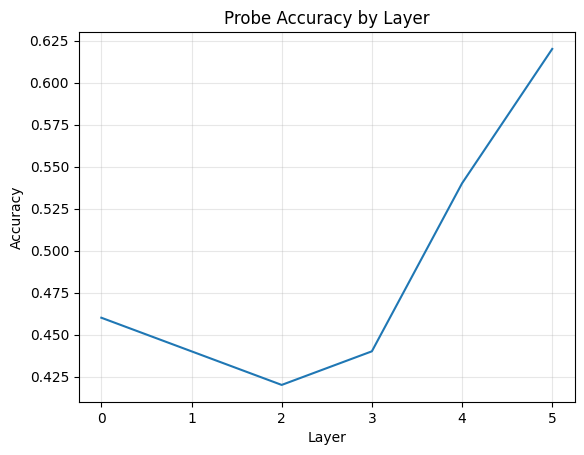

In [12]:
plt.plot(layer_wise_accuracies)
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.title('Probe Accuracy by Layer')
plt.grid(alpha=0.3)
plt.show()

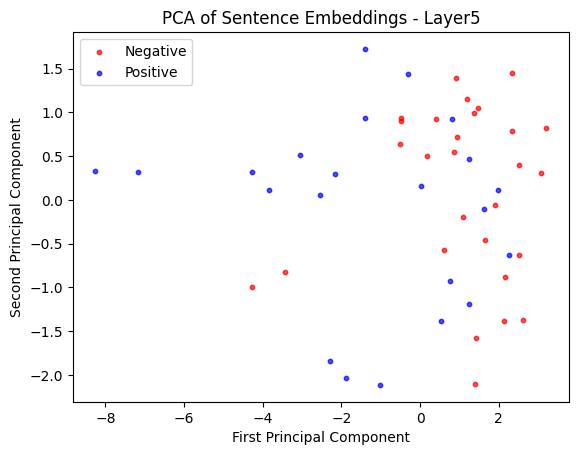

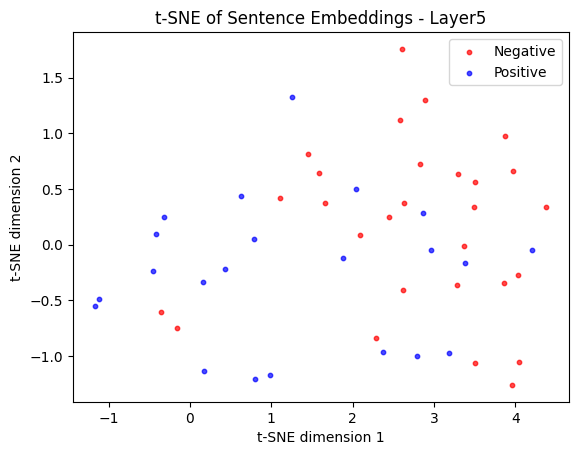

In [13]:
layer_num = 5
embeddings=get_embeddings_from_model(model, tokenizer, layer_num=layer_num, data=train_dataset['text'], batch_size=16)
labels=torch.tensor(train_dataset['label'],  dtype=torch.long).cpu().numpy().tolist()
visualize_embeddings(embeddings=embeddings, labels=labels, layer_num=layer_num, visualization_method='PCA')
visualize_embeddings(embeddings=embeddings, labels=labels, layer_num=layer_num, visualization_method='t-SNE')

In [14]:
best_layer = 5
test_sequences = ['This movie was so bad, I think I vomited at the end.', 'It was pretty good, I like most of the scenes.']
embeddings = get_embeddings_from_model(model=model, tokenizer=tokenizer, layer_num=best_layer, data=test_sequences, batch_size=batch_size)
preds = probe.predict(data_embeddings=embeddings)
predictions = ['Positive' if pred == 1 else 'Negative' for pred in preds]
print(f'Predictions for test sequences: {predictions}')

Predictions for test sequences: ['Negative', 'Positive']
